In [123]:
import torch
import dlc_practical_prologue as prologue

from torch import optim
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt

In [124]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        _, _, result = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(result, 1)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [125]:
def train_model(model, train_input, train_target, train_classes, nb_epochs, mini_batch_size, AL):
    criterion = nn.CrossEntropyLoss()
    eta = 1e-3
    loss_coeff = 10
    optimizer = optim.Adam(model.parameters(), lr = eta)
    
    for e in range(nb_epochs):    
        
        for b in range(0, train_input.size(0), mini_batch_size):
            digit1, digit2, result = model(train_input.narrow(0, b, mini_batch_size))
                
            loss_result = criterion(result, train_target.narrow(0, b, mini_batch_size))
            loss_digit1 = criterion(digit1, train_classes[:,0].narrow(0, b, mini_batch_size))
            loss_digit2 = criterion(digit2, train_classes[:,1].narrow(0, b, mini_batch_size))
            
            if AL:
                loss = loss_result + loss_coeff*loss_digit1 + loss_coeff*loss_digit2
            else:
                loss = loss_result
            
            model.zero_grad()
            loss.backward()
            optimizer.step()

In [126]:
class MLP_NoWS_NoAL(nn.Module):
    def __init__(self):
        super(MLP_NoWS_NoAL, self).__init__()
        
        nb_hidden = 100
        input_size = 14*14
        
        self.layers1 = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1) #Technically this is already in the nn.CrossEntropyLoss()
        )
        
        self.layers2 = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1)
        )
        
        self.layers_comp = nn.Sequential(
            nn.Linear(20, 200),
            nn.ReLU(),
            nn.Linear(200, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2)
        )
        
    def forward(self, x):
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]
        
        first_digit = first_digit.view(first_digit.size(0),-1) #torch.reshape() can also be used
        second_digit = second_digit.view(second_digit.size(0),-1)
        
        first_digit = self.layers1(first_digit)
        second_digit = self.layers2(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layers_comp(result)
    
        return first_digit, second_digit, result

In [127]:
class MLP_WS_NoAL(nn.Module):
    def __init__(self):
        super(MLP_WS_NoAL, self).__init__()
        
        nb_hidden = 100
        input_size = 14*14
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1) #Technically this is already in the nn.CrossEntropyLoss()
        )
        
        self.layers_comp = nn.Sequential(
            nn.Linear(20, 200),
            nn.ReLU(),
            nn.Linear(200, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2)
        )
        
    def forward(self, x):
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]
        
        first_digit = first_digit.view(first_digit.size(0),-1) #torch.reshape() can also be used
        second_digit = second_digit.view(second_digit.size(0),-1)
        
        first_digit = self.layers(first_digit)
        second_digit = self.layers(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layers_comp(result)
    
        return first_digit, second_digit, result

In [128]:
class MLP_NoWS_AL(nn.Module):
    def __init__(self):
        super(MLP_NoWS_AL, self).__init__()
        
        nb_hidden = 100
        input_size = 14*14
        
        self.layers1 = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1) #Technically this is already in the nn.CrossEntropyLoss()
        )
        
        self.layers2 = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1)
        )
        
        self.layers_comp = nn.Sequential(
            nn.Linear(20, 200),
            nn.ReLU(),
            nn.Linear(200, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2)
        )
        
    def forward(self, x):
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]
        
        first_digit = first_digit.view(first_digit.size(0),-1) #torch.reshape() can also be used
        second_digit = second_digit.view(second_digit.size(0),-1)
        
        first_digit = self.layers1(first_digit)
        second_digit = self.layers2(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layers_comp(result)
    
        return first_digit, second_digit, result

In [129]:
class MLP_WS_AL(nn.Module):
    def __init__(self):
        super(MLP_WS_AL, self).__init__()
        
        nb_hidden = 100
        input_size = 14*14
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, nb_hidden),
            nn.Linear(nb_hidden, nb_hidden),
            nn.Linear(nb_hidden, 10),
            nn.LogSoftmax(dim=1)
        )
        
        self.layers_comp = nn.Sequential(
            nn.Linear(20, 200),
            nn.ReLU(),
            nn.Linear(200, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2)
        )
        
    def forward(self, x):
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]
        
        first_digit = first_digit.view(first_digit.size(0),-1) #torch.reshape() can also be used
        second_digit = second_digit.view(second_digit.size(0),-1)
        
        first_digit = self.layers(first_digit)
        second_digit = self.layers(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layers_comp(result)
    
        return first_digit, second_digit, result

In [130]:
class Conv_NoWS_NoAL(nn.Module):
    def __init__(self):
        super(Conv_NoWS_NoAL, self).__init__()
        #Input channels = 1, output channels = 32
        self.layer1_first_digit = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 1, output channels = 32
        self.layer1_second_digit = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2_first_digit = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2_second_digit = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Formula to get out_put size (in_size - kernel_size + 2*(padding)) / stride) + 1
        # first layer (14-5+2*2)/1 +1 = 14/2 = 7
        # second layer (7 -4 +2*2)/1 +1 = 8/2 = 4
        # 4 * 4 * 64 input features, 1000 output features
        self.fc1_first_digit = nn.Linear(4 * 4 * 64, 1000)
        self.fc1_second_digit = nn.Linear(4 * 4 * 64, 1000)
        
        # 1000 input features, 2 output features
        self.fc2_first_digit = nn.Linear(1000, 10)
        self.fc2_second_digit = nn.Linear(1000, 10)
        
        #Comparison of the two digits
        self.layer_comp = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 2))
        
    def forward(self, x):
        
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]

        first_digit = self.layer1_first_digit(first_digit)
        second_digit = self.layer1_second_digit(second_digit)
        
        first_digit = self.layer2_first_digit(first_digit)
        second_digit = self.layer2_second_digit(second_digit)
    
        first_digit = F.relu(self.fc1_first_digit(first_digit.view(-1, 4 * 4 * 64)))
        second_digit = F.relu(self.fc1_second_digit(second_digit.view(-1, 4 * 4 * 64)))
        
        first_digit = self.fc2_first_digit(first_digit)
        second_digit = self.fc2_second_digit(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layer_comp(result)
        
        return first_digit, second_digit, result

In [131]:
class Conv_WS_NoAL(nn.Module):
    def __init__(self):
        super(Conv_WS_NoAL, self).__init__()
        
        #Input channels = 1, output channels = 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        
        # Formula to get out_put size (in_size - kernel_size + 2*(padding)) / stride) + 1
        # first layer (14-5+2*2)/1 +1 = 14/2 = 7
        # second layer (7 -4 +2*2)/1 +1 = 8/2 = 4
        # 4 * 4 * 64 input features, 1000 output features
        self.fc1 = nn.Linear(4 * 4 * 64, 1000)
        
        # 1000 input features, 2 output features
        self.fc2 = nn.Linear(1000, 10)

        #Comparison of the two digits
        self.layer_comp = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 2))
        
    def forward(self, x):
        
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]

        first_digit = self.layer1(first_digit)
        second_digit = self.layer1(second_digit)
        
        first_digit = self.layer2(first_digit)
        second_digit = self.layer2(second_digit)
    
        first_digit = F.relu(self.fc1(first_digit.view(-1, 4 * 4 * 64)))
        second_digit = F.relu(self.fc1(second_digit.view(-1, 4 * 4 * 64)))
        
        first_digit = self.fc2(first_digit)
        second_digit = self.fc2(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layer_comp(result)
        
        return first_digit, second_digit, result

In [132]:
class Conv_NoWS_AL(nn.Module):
    def __init__(self):
        super(Conv_NoWS_AL, self).__init__()
        #Input channels = 1, output channels = 32
        self.layer1_first_digit = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 1, output channels = 32
        self.layer1_second_digit = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2_first_digit = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2_second_digit = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Formula to get out_put size (in_size - kernel_size + 2*(padding)) / stride) + 1
        # first layer (14-5+2*2)/1 +1 = 14/2 = 7
        # second layer (7 -4 +2*2)/1 +1 = 8/2 = 4
        # 4 * 4 * 64 input features, 1000 output features
        self.fc1_first_digit = nn.Linear(4 * 4 * 64, 1000)
        self.fc1_second_digit = nn.Linear(4 * 4 * 64, 1000)
        
        # 1000 input features, 2 output features
        self.fc2_first_digit = nn.Linear(1000, 10)
        self.fc2_second_digit = nn.Linear(1000, 10)
        
        #Comparison of the two digits
        self.layer_comp = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 2))
        
    def forward(self, x):
        
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]

        first_digit = self.layer1_first_digit(first_digit)
        second_digit = self.layer1_second_digit(second_digit)
        
        first_digit = self.layer2_first_digit(first_digit)
        second_digit = self.layer2_second_digit(second_digit)
    
        first_digit = F.relu(self.fc1_first_digit(first_digit.view(-1, 4 * 4 * 64)))
        second_digit = F.relu(self.fc1_second_digit(second_digit.view(-1, 4 * 4 * 64)))
        
        first_digit = self.fc2_first_digit(first_digit)
        second_digit = self.fc2_second_digit(second_digit)
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layer_comp(result)
        
        return first_digit, second_digit, result

In [133]:
class Conv_WS_AL(nn.Module):
    def __init__(self):
        super(Conv_WS_AL, self).__init__()
        
        #Input channels = 1, output channels = 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2))
        
        #Input channels = 32, output channels = 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2))
        
        # Formula to get out_put size (in_size - kernel_size + 2*(padding)) / stride) + 1
        # first layer (14 - 3 + 2*1) + 1 = 14/2 = 7
        # second layer (7 - 2 + 2*1) + 1 = 8/2 = 4
        # 4 * 4 * 64 input features, 1000 output features
        self.fc = nn.Sequential(
            nn.Linear(4 * 4 * 64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10))

        #Comparison of the two digits
        self.layer_comp = nn.Sequential(
            nn.Linear(20, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 2))
        
    def forward(self, x):
        
        first_digit = x[:,[0]]
        second_digit = x[:,[1]]

        first_digit = self.layer1(first_digit)
        second_digit = self.layer1(second_digit)
        
        first_digit = self.layer2(first_digit)
        second_digit = self.layer2(second_digit)
    
        first_digit = self.fc(first_digit.view(-1, 4 * 4 * 64))
        second_digit = self.fc(second_digit.view(-1, 4 * 4 * 64))
        
        result = torch.cat((first_digit, second_digit), dim=1, out=None)
        result = self.layer_comp(result)
        
        return first_digit, second_digit, result

In [134]:
def get_tests(n):
    M = []
    for k in range (0, n):
        L = []
        _, _, _, test_input, test_target, test_classes =  prologue.generate_pair_sets(1000)
        L.append(test_input)
        L.append(test_target)
        L.append(test_classes)
        M.append(L)
    return M

In [135]:
def main_yolo(model, nb_epochs, AL):
    
    # model = Conv_WS_AL()
    mini_batch_size = 100
    Train_error = []
    Test_error = []
    
    train_input, train_target, train_classes,_, _, _ \
    = prologue.generate_pair_sets(1000)

    for e in range(1, nb_epochs+1):
        
        # AL = True
        train_model(model, train_input, train_target, train_classes, e, mini_batch_size, AL)
        L = get_tests(10)

        nb_train_errors = compute_nb_errors(model, train_input, train_target, mini_batch_size)
        Train_error.append(nb_train_errors/10)

        avg_nb_test_error = 0

        for k in range (0, len(L)):
            nb_test_errors = compute_nb_errors(model, L[k][0], L[k][1], mini_batch_size)
            avg_nb_test_error += nb_test_errors

        avg_nb_test_error /= len(L)
        Test_error.append(avg_nb_test_error/10)
        
    return Train_error, Test_error

In [136]:
#Train_error, Test_error = main_yolo(3)
#print(Train_error)
#print(Test_error)

/Users/churchhyll/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/churchhyll/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/churchhyll/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/churchhyll/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


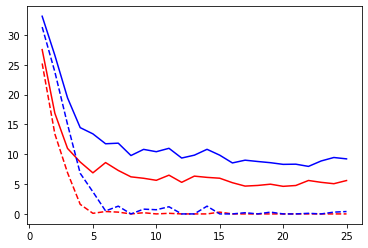

In [137]:
model_1 = Conv_WS_AL()
model_2 = MLP_WS_AL()

AL = True
NoAL = False

nb_epochs = 25

train_error_1, test_error_1 = main_yolo(model_1, nb_epochs, AL)
train_error_2, test_error_2 = main_yolo(model_2, nb_epochs, AL)

# yolo
epochs = torch.linspace(1, nb_epochs, steps=nb_epochs)
plt.plot(epochs, train_error_1,'r--', epochs, test_error_1,'r',
         epochs, train_error_2, 'b--', epochs, test_error_2, 'b')